# Showcase of the "to_sql" functionality of mlinspect

It will be shown how parts of the original mlinspect example pipelines
"healthcare" and "compas" will be inspected using the additional "to_sql"
functionality.

## First install the required packages

In [ ]:
# Install the pip packages in the current Jupyter kernel
import sys
!{sys.executable} -m pip install faker

## Some parameters you might want to set:#

In [8]:
import pathlib
import timeit
from inspect import cleandoc
import matplotlib.pyplot as plt

from mlinspect.to_sql.dbms_connectors.postgresql_connector import PostgresqlConnector
from mlinspect.to_sql.dbms_connectors.umbra_connector import UmbraConnector
from pandas_connector import PandasConnector
from mlinspect import PipelineInspector

from pandas_connector import PandasConnector
from _benchmark_utility import plot_compare, ROOT_DIR, PLOT_DIR
from _code_as_string import Join, GroupBy, Selection, Projection

DO_CLEANUP = True
SIZES = [(10 ** i) for i in range(2, 5, 1)]
BENCH_REP = 10

# DBMS related:
UMBRA_DIR = r"/home/luca/Documents/Bachelorarbeit/umbra-students"
UMBRA_USER = "postgres"
UMBRA_PW = " "
UMBRA_DB = ""
UMBRA_PORT = 5433
UMBRA_HOST = "/tmp/"

POSTGRES_USER = "luca"
POSTGRES_PW = "password"
POSTGRES_DB = "healthcare_benchmark"
POSTGRES_PORT = 5432
POSTGRES_HOST = "localhost"

# Data Generation

To be able to benchmark and compare the different approaches, some datasets
will need to be generated before. The datasets are just and expansion of the
original ones.

In [3]:
from data_generation._compas_data_generation import generate_compas_dataset
from data_generation._healthcare_data_generation import generate_healthcare_dataset

# compas_tain, compas_test \
COMPAS_DATA_PATHS = generate_compas_dataset(SIZES)
# healthcare_histories, healthcare_patients \
HEALTHCARE_DATA_PATHS = generate_healthcare_dataset(SIZES)

Data generated or found for: size = 100 -- compas
Data generated or found for: size = 1000 -- compas
Data generated or found for: size = 10000 -- compas
Data generated or found for: size = 100 -- healthcare
Data generated or found for: size = 1000 -- healthcare
Data generated or found for: size = 10000 -- healthcare


## Benchmark simple operations (not exhaustive)

Killed
No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


ITERATION: 0 - for table size of: 100
Executing Query in Umbra...
Done in 0.0003177000000000001!
Executing Query in Postgres...
Done in 0.17!
Executing Query in Pandas...
Done in 9.017838099998698!
Executing Query in Umbra...
Done in 0.00010540000000000003!
Executing Query in Postgres...
Done in 0.04229999999999999!
Executing Query in Pandas...
Done in 3.31612900000664!
Executing Query in Umbra...
Done in 0.0002403!
Executing Query in Postgres...
Done in 0.0792!
Executing Query in Pandas...
Done in 3.298348599992096!
Executing Query in Umbra...
Done in 0.0005539!
Executing Query in Postgres...
Done in 0.09530000000000001!
Executing Query in Pandas...
Done in 12.675372199998947!


Killed
No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


ITERATION: 1 - for table size of: 1000
Executing Query in Umbra...
Done in 0.0014258!
Executing Query in Postgres...
Done in 1.0085000000000002!
Executing Query in Pandas...
Done in 8.7979378!
Executing Query in Umbra...
Done in 0.0002056!
Executing Query in Postgres...
Done in 0.24170000000000003!
Executing Query in Pandas...
Done in 2.859052700000575!
Executing Query in Umbra...
Done in 0.00019869999999999995!
Executing Query in Postgres...
Done in 0.2916!
Executing Query in Pandas...
Done in 2.7112010999985614!
Executing Query in Umbra...
Done in 0.0004556!
Executing Query in Postgres...
Done in 0.5596!
Executing Query in Pandas...
Done in 6.593199099995672!


Killed
No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


ITERATION: 2 - for table size of: 10000
Executing Query in Umbra...
Done in 0.0036105000000000004!
Executing Query in Postgres...
Done in 9.538!
Executing Query in Pandas...
Done in 30.77262959999416!
Executing Query in Umbra...
Done in 0.0006693000000000001!
Executing Query in Postgres...
Done in 1.6340000000000003!
Executing Query in Pandas...
Done in 8.428138399995078!
Executing Query in Umbra...
Done in 0.0003818!
Executing Query in Postgres...
Done in 2.1203000000000003!
Executing Query in Pandas...
Done in 8.322655599999962!
Executing Query in Umbra...
Done in 0.0007373000000000001!
Executing Query in Postgres...
Done in 3.6430999999999996!
Executing Query in Pandas...
Done in 13.235964799991962!


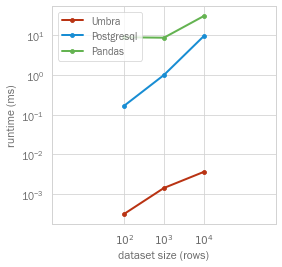

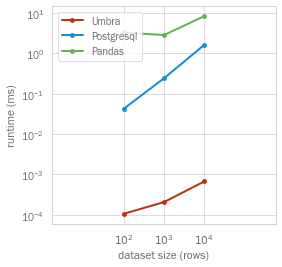

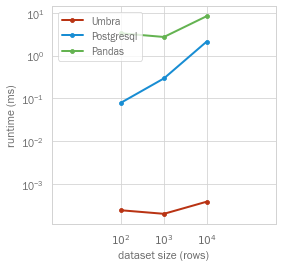

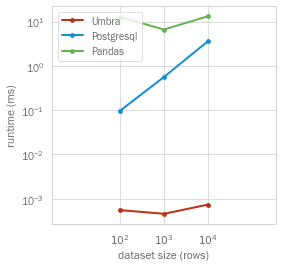

In [10]:
# Based on mlinspect benchmarks.

def simple_op_benchmark():
    t1_name = "histories"
    t2_name = "patients"

    operations = ["Join", "Select", "Project", "GroupBy"]

    umbra_times = [[] for _ in operations]
    postgres_times = [[] for _ in operations]
    pandas_times = [[] for _ in operations]

    postgres = PostgresqlConnector(dbname="healthcare_benchmark", user="luca", password="password", port=5432,
                                   host="localhost")
    pandas = PandasConnector()
    repetitions = 10
    for i, (table1, table2) in enumerate(HEALTHCARE_DATA_PATHS):

        umbra = UmbraConnector(dbname="", user="postgres", password=" ", port=5433, host="/tmp/",
                               umbra_dir=UMBRA_DIR)

        umbra.add_csv(table_name=t2_name, path_to_csv=table2, null_symbols=["?"], delimiter=",", header=True)
        umbra.add_csv(table_name=t1_name, path_to_csv=table1, null_symbols=["?"], delimiter=",", header=True)

        postgres.add_csv(table_name=t2_name, path_to_csv=table2, null_symbols=["?"], delimiter=",", header=True)
        postgres.add_csv(table_name=t1_name, path_to_csv=table1, null_symbols=["?"], delimiter=",", header=True)

        print(f"ITERATION: {i} - for table size of: {SIZES[i]}")

        input_join = t1_name, t2_name, "ssn"
        umbra_times[0].append(umbra.benchmark_run(Join.get_sql_code(*input_join), repetitions))
        postgres_times[0].append(postgres.benchmark_run(Join.get_sql_code(*input_join), repetitions))
        pandas_times[0].append(
            pandas.benchmark_run(Join.get_pandas_code(table1, table2, "ssn"), repetitions=repetitions))

        input_sel = t1_name, "complications", ">", "5"
        umbra_times[1].append(umbra.benchmark_run(Selection.get_sql_code(*input_sel), repetitions))
        postgres_times[1].append(postgres.benchmark_run(Selection.get_sql_code(*input_sel), repetitions))
        pandas_times[1].append(
            pandas.benchmark_run(Selection.get_pandas_code(table1, "complications", ">", "5"),
                                 repetitions=repetitions))

        input_project = t1_name, "smoker"
        umbra_times[2].append(umbra.benchmark_run(Projection.get_sql_code(*input_project), repetitions))
        postgres_times[2].append(postgres.benchmark_run(Projection.get_sql_code(*input_project), repetitions))
        pandas_times[2].append(
            pandas.benchmark_run(Projection.get_pandas_code(table1, "smoker"), repetitions=repetitions))

        input_project = t1_name, "smoker", "complications", "AVG"
        umbra_times[3].append(umbra.benchmark_run(GroupBy.get_sql_code(*input_project), repetitions))
        postgres_times[3].append(postgres.benchmark_run(GroupBy.get_sql_code(*input_project), repetitions))
        pandas_times[3].append(
            pandas.benchmark_run(GroupBy.get_pandas_code(table1, "smoker", "complications", "mean"),
                                 repetitions=repetitions))
        # in the end we have 3 lists == [[*joins*][*selections*][*projections*]]

    names = ["Umbra", "Postgresql", "Pandas"]
    for i, title in enumerate(operations):
        table = [umbra_times[i], postgres_times[i], pandas_times[i]]
        plot_compare(title, SIZES, all_y=table, all_y_names=names, save=True)


simple_op_benchmark()

### The original results:
**Join**:

![](./plots/Join.png)

**GroupBy**:

![](./plots/GroupBy.png)

**Select**:

![](./plots/Select.png)

**Project**:

![](./plots/Project.png)



## Benchmark pure pipeline:

In [5]:
def get_healthcare_pipe_code_orig(path_histories, path_patients):
    setup_code = cleandoc("""
        import os
        import pandas as pd
        from mlinspect.utils import get_project_root
        """)

    test_code = cleandoc(f"""
        COUNTIES_OF_INTEREST = ['county2', 'county3']

        patients = pd.read_csv('{path_patients}', na_values='?')
        histories = pd.read_csv('{path_histories}', na_values='?')

        data = patients.merge(histories, on=['ssn'])
        complications = data.groupby('age_group') \
            .agg(mean_complications=('complications', 'mean'))
        data = data.merge(complications, on=['age_group'])
        data['label'] = data['complications'] > 1.2 * data['mean_complications']
        data = data[['smoker', 'last_name', 'county', 'num_children', 'race', 'income', 'label']]
        data = data[data['county'].isin(COUNTIES_OF_INTEREST)]
        """)

    return setup_code, test_code


def get_healthcare_SQL_str(pipeline_code, mode, materialize):
    PipelineInspector \
        .on_pipeline_from_string(pipeline_code) \
        .execute_in_sql(dbms_connector=None, mode=mode, materialize=materialize)

    setup_file = \
        pathlib.Path(r"/home/luca/Documents/Bachelorarbeit/mlinspect/mlinspect/to_sql/generated_code/create_table.sql")
    test_file = \
        pathlib.Path(r"/home/luca/Documents/Bachelorarbeit/mlinspect/mlinspect/to_sql/generated_code/pipeline.sql")

    with setup_file.open("r") as file:
        setup_code = file.read()

    with test_file.open("r") as file:
        test_code = file.read()

    return setup_code, test_code

ITERATION: 0 - for table size of: 100

Just translation to SQL is performed! 
-> SQL-Code placed at: mlinspect/to_sql/generated_code



No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


Executing Query in Umbra...
Done in 0.0009016999999999999!
Executing Query in Postgres...
Done in 0.45840000000000003!
Executing Query in Pandas...
Done in 27.8417558000001!
ITERATION: 1 - for table size of: 1000

Just translation to SQL is performed! 
-> SQL-Code placed at: mlinspect/to_sql/generated_code



Killed
No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


Executing Query in Umbra...
Done in 0.0013144!
Executing Query in Postgres...
Done in 3.201200000000001!
Executing Query in Pandas...
Done in 16.784041699997942!
ITERATION: 2 - for table size of: 10000

Just translation to SQL is performed! 
-> SQL-Code placed at: mlinspect/to_sql/generated_code



Killed
No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


Executing Query in Umbra...
Done in 0.004005!
Executing Query in Postgres...
Done in 32.3308!
Executing Query in Pandas...
Done in 45.57387759999756!
Plotting..


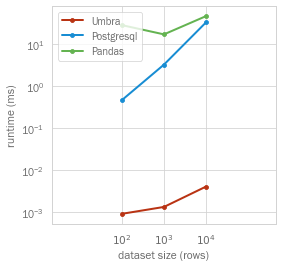

In [9]:
def pure_pipeline_benchmark():
    umbra_times = []
    postgres_times = []
    pandas_times = []

    postgres = PostgresqlConnector(dbname="healthcare_benchmark", user="luca", password="password", port=5432,
                                   host="localhost")
    pandas = PandasConnector()

    for i, (path_to_csv_his, path_to_csv_pat) in enumerate(HEALTHCARE_DATA_PATHS):
        print(f"ITERATION: {i} - for table size of: {SIZES[i]}")

        setup_code_orig, test_code_orig = get_healthcare_pipe_code_orig(path_to_csv_his, path_to_csv_pat)

        setup_code, test_code = get_healthcare_SQL_str(setup_code_orig + "\n" + test_code_orig, mode="CTE",
                                                       materialize=False)

        ################################################################################################################
        # time Umbra:
        umbra = UmbraConnector(dbname="", user="postgres", password=" ", port=5433, host="/tmp/", umbra_dir=UMBRA_DIR)
        umbra.run(setup_code)
        umbra_times.append(umbra.benchmark_run(test_code, repetitions=BENCH_REP))

        ################################################################################################################
        # time Postgres:
        postgres.run(setup_code)
        postgres_times.append(postgres.benchmark_run(test_code, repetitions=BENCH_REP))

        ################################################################################################################
        # time Pandas:
        pandas_times.append(pandas.benchmark_run(pandas_code=test_code_orig, setup_code=setup_code_orig,
                                                 repetitions=BENCH_REP))
        ################################################################################################################

    print(f"Plotting..")
    names = ["Umbra", "Postgresql", "Pandas"]
    title = "HealthcarePurePipeComparison"
    table = [umbra_times, postgres_times, pandas_times]
    plot_compare(title, SIZES, all_y=table, all_y_names=names, save=True)

pure_pipeline_benchmark()

### The original results:
**Join**:

![](./plots/HealthcarePurePipeComparison.png)

## Benchmark Inspection:

In [ ]:
def get_inspection_code(pipeline_code, to_sql, dbms_connector, one_run=False):
    setup_code = cleandoc(f"""
from inspect import cleandoc
from mlinspect.utils import get_project_root
from mlinspect import PipelineInspector
from mlinspect.inspections import RowLineage, MaterializeFirstOutputRows
from mlinspect.checks import NoBiasIntroducedFor, NoIllegalFeatures
from demo.feature_overview.no_missing_embeddings import NoMissingEmbeddings
from inspect import cleandoc
from example_pipelines.healthcare import custom_monkeypatching
from mlinspect.to_sql.dbms_connectors.postgresql_connector import PostgresqlConnector
from mlinspect.to_sql.dbms_connectors.umbra_connector import UmbraConnector
from mlinspect import PipelineInspector

dbms_connector_u = UmbraConnector(dbname=\'{UMBRA_DB}\', user=\'{UMBRA_USER}\', password=\'{UMBRA_PW}\',
    port={UMBRA_PORT}, host=\'{UMBRA_HOST}\', umbra_dir= r\'{UMBRA_DIR}\')
dbms_connector_p = PostgresqlConnector(dbname=\'{POSTGRES_DB}\', user=\'{POSTGRES_USER}\',
    password=\'{POSTGRES_PW}\', port={POSTGRES_PORT}, host=\'{POSTGRES_HOST}\')

pipeline_code = cleandoc(f\"\"\"{pipeline_code}\"\"\")

pipeline_inspector = PipelineInspector.on_pipeline_from_string(pipeline_code) \\
    .add_custom_monkey_patching_module(custom_monkeypatching) \\
    .add_check(NoBiasIntroducedFor([\'age_group\', \'race\'])) \\
    .add_check(NoIllegalFeatures()) \\
    .add_check(NoMissingEmbeddings()) \\
    .add_required_inspection(RowLineage(5)) \\
    .add_required_inspection(MaterializeFirstOutputRows(5))
    """)
    if to_sql:
        return setup_code, f"pipeline_inspector.execute_in_sql(dbms_connector={dbms_connector}, " \
                           f"sql_one_run={one_run}, mode=\'CTE\')"

    return setup_code, f"pipeline_inspector.execute()"


def run(pipeline_code, to_sql=False, dbms_connector=None, one_run=False):
    setup_code, test_code = get_inspection_code(pipeline_code, to_sql, dbms_connector, one_run)
    if to_sql:
        result = []
        for _ in range(BENCH_REP):
            # This special case is necessary to deduct the time for dropping the existing tables and views!
            result.append(timeit.timeit(test_code, setup=setup_code, number=1) * 1000)  # in s
        return sum(result) / BENCH_REP

    return (timeit.timeit(test_code, setup=setup_code, number=BENCH_REP) / BENCH_REP) * 1000  # in s


def pipeline_inspection_benchmark(display_hardware_usage: bool = False):
    pandas_times = []
    postgres_times = []
    umbra_times = []
    for sql_one_run in [False]:
        for i, (path_to_csv_pat, path_to_csv_his) in enumerate(HEALTHCARE_DATA_PATHS):
            setup_code, test_code = get_healthcare_pipe_code_orig(path_to_csv_pat, path_to_csv_his)
            pipe_code = setup_code + "\n" + test_code

            print(f"Running pandas...  -- size {SIZES[i]}")
            pandas_times.append(run(pipe_code, to_sql=False, dbms_connector=None, one_run=sql_one_run))
            print(f"Running postgres...  -- size {SIZES[i]}")
            postgres_times.append(run(pipe_code, to_sql=True, dbms_connector="dbms_connector_p", one_run=sql_one_run))
            print(f"Running umbra... -- size {SIZES[i]}")
            umbra_times.append(run(pipe_code, to_sql=True, dbms_connector="dbms_connector_u", one_run=sql_one_run))

            # sys.argv = ["psrecord", "--duration=100", "--log=activity.txt", "1540"]
            # main()

        names = ["Pandas", "Postgresql", "Umbra"]
        title = "healthcare_pandas_compare"
        table = [pandas_times, postgres_times, umbra_times]
        plot = plot_compare(title, SIZES, all_y=table, all_y_names=names, save=True)
        plot.show()

pipeline_inspection_benchmark()

Running pandas...  -- size 100


Killed
No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


<connection object at 0x7f2cd96dfc20; dsn: 'user=luca password=xxx dbname=healthcare_benchmark host=localhost port=5432', closed: 0>
Running postgres...  -- size 100


No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


In [11]:
# Clean_up:

if DO_CLEANUP:
    [f.unlink() for f in PLOT_DIR.glob("*_.png") if f.is_file()]